In [2]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
#from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [16]:
data_dir = 'Resources/nasa_bearing/2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    #print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    #print(dataset)
    dataset_mean_abs = np.array(dataset.abs().mean())
    #print(len(dataset_mean_abs))
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

In [17]:
merged_data

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.12.10.32.39,0.058333,0.071832,0.083242,0.043067
2004.02.12.10.42.39,0.058995,0.074006,0.084435,0.044541
2004.02.12.10.52.39,0.060236,0.074227,0.083926,0.044443
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004.02.19.05.42.39,0.453335,0.161016,0.137440,0.119047
2004.02.19.05.52.39,0.337583,0.132400,0.144992,0.092125
2004.02.19.06.02.39,0.351111,0.152266,0.151299,0.100817
2004.02.19.06.12.39,0.001857,0.003732,0.003656,0.001786


In [18]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<AxesSubplot:>

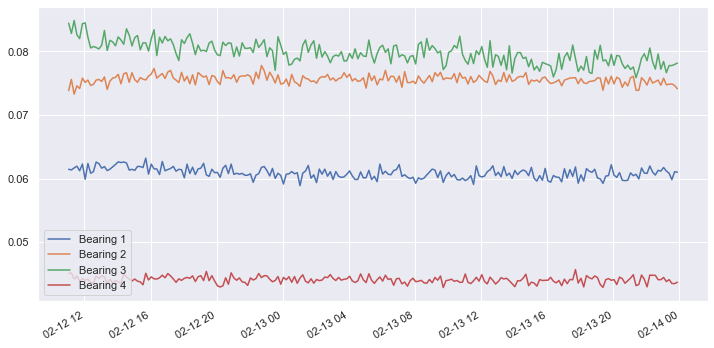

In [19]:
#splitting the training and test data
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

In [20]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

In [21]:
X_train

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737
2004-02-12 11:42:39,0.542705,0.197430,0.682892,0.354536
...,...,...,...,...
2004-02-13 23:12:39,0.531622,0.326219,0.087451,0.332808
2004-02-13 23:22:39,0.451104,0.345965,0.212896,0.443161
2004-02-13 23:32:39,0.218776,0.356038,0.212484,0.229761
2004-02-13 23:42:39,0.504087,0.300491,0.232546,0.215409


In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [23]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [24]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [25]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [26]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [27]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [28]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [29]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [30]:
mean_distr = data_train.mean(axis=0)

In [31]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

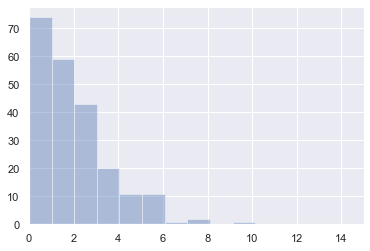

In [32]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

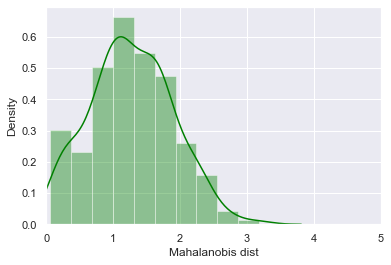

In [34]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [35]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


In [36]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

<AxesSubplot:>

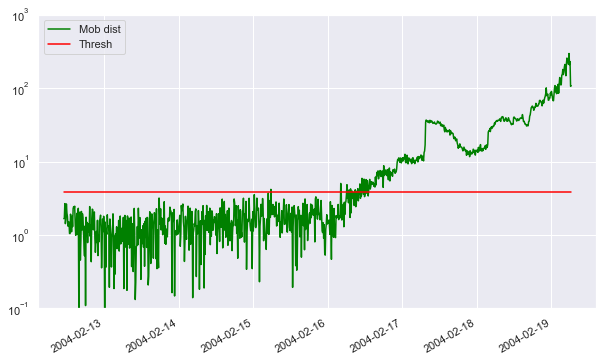

In [37]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

Autoencoder model for anomaly detection

In [42]:
import tensorflow as tf

seed(10)
tf.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [43]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
21/21 [==============================] - 1s 10ms/step - loss: 0.1606 - val_loss: 0.0879
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.1116 - val_loss: 0.0590
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0365
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0248
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0212
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0221
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0186 - val_loss: 0.0233
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0179 - val_loss: 0.0222
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0171 - val_loss: 0.0218
Epoch 10/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0165 - val_loss: 0.0208
Epoch 11

21/21 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0131
Epoch 84/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0133
Epoch 85/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0134
Epoch 86/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 87/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0130
Epoch 88/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 89/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0128
Epoch 90/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 91/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0128
Epoch 92/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0136
Epoch 93/100


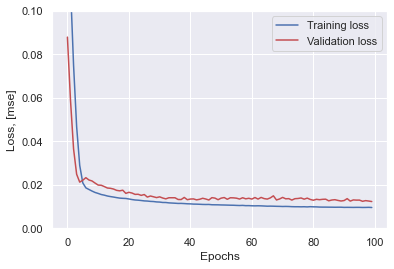

In [44]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

7/7 [==============================] - 0s 2ms/step


C:\Users\levfl\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

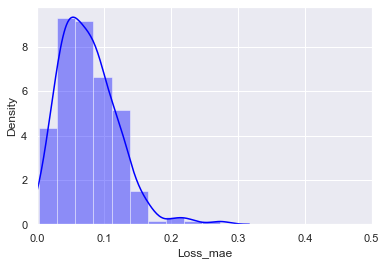

In [45]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [46]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

24/24 [==============================] - 0s 1ms/step


,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.135230,0.3,False
2004-02-14 00:02:39,0.103883,0.3,False
2004-02-14 00:12:39,0.031544,0.3,False
2004-02-14 00:22:39,0.072124,0.3,False
2004-02-14 00:32:39,0.120766,0.3,False


In [47]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

7/7 [==============================] - 0s 5ms/step


<AxesSubplot:>

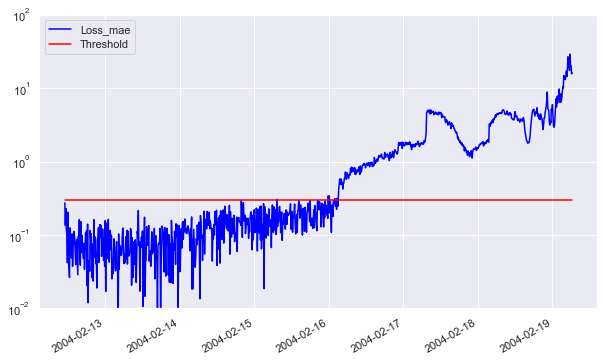

In [50]:
scored.plot(logy=True,  
    figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])